# **Klasifikasi Citra Satelit dan Visualisasi Spasial**

Project ini bertujuan untuk melakukan analisis spasial terhadap citra satelit wilayah Jakarta dengan dua pendekatan: klasifikasi berbasis machine learning (Random Forest) dan segmentasi berbasis unsupervised learning (K-Means).
Tujuannya adalah untuk memetakan risiko atau tutupan lahan secara lebih informatif dan interaktif.
Proyek ini mencakup empat tahapan utama:


1.   Klasifikasi Spasial: Melatih model Random Forest menggunakan data vektor(shapefile) dan menghasilkan peta prediksi kategori.
2. Segmentasi Citra: Menerapkan algoritma K-Means pada citra Landsat untuk membentuk wilayah homogen berdasarkan spektral.
3. Visualisasi Interaktif: Menggabungkan hasil klasifikasi dan segmentasi dalam peta interaktif menggunakan Folium.
4. Evaluasi & Analisis: Mengevaluasi performa model Random Forest dan
membandingkannya dengan hasil segmentasi K-Means.

Data yang digunakan:
*   Data supervised - random forest : processed_jkt.shp
*   Data unsupervised - kmeans :landsat8_dki_jakpus_2017.tif


# **1. Klasifikasi Spasial**

In [ ]:
# Import Libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Baca Data
shp_file = '/content/processed_jkt.shp'
shp_file = gpd.read_file(shp_file)
shp_file.head()

OBJECT_ID   KODE_DESA            DESA      KODE     PROVINSI  \
0    25477.0  3173031006       KEAGUNGAN  317303.0  DKI JAKARTA   
1    25478.0  3173031007          GLODOK  317303.0  DKI JAKARTA   
2    25397.0  3171031003   HARAPAN MULIA  317103.0  DKI JAKARTA   
3    25400.0  3171031006    CEMPAKA BARU  317103.0  DKI JAKARTA   
4    25378.0  3101011001  PULAU PANGGANG  310101.0  DKI JAKARTA   

           KAB_KOTA               KECAMATAN      DESA_KELUR  JUMLAH_PEN  \
0     JAKARTA BARAT              TAMAN SARI       KEAGUNGAN     21609.0   
1     JAKARTA BARAT              TAMAN SARI          GLODOK      9069.0   
2     JAKARTA PUSAT               KEMAYORAN   HARAPAN MULIA     29085.0   
3     JAKARTA PUSAT               KEMAYORAN    CEMPAKA BARU     41913.0   
4  KEPULAUAN SERIBU  KEPULAUAN SERIBU UTARA  PULAU PANGGANG      6947.0   

   JUMLAH_KK  ...  luas_km2  keliling_k  kompaksi  jarak_ke_m    kepadata_1  \
0     7255.0  ...  0.353146    2.593777  0.659629    3.039610  61189.911080   
1     3273.0  ...  0.365613    2.405313  0.794124    3.703862  24804.913958   
2     9217.0  ...  0.528013    3.645967  0.499147    3.212556  55083.883622   
3    13766.0  ...  0.963938    5.140281  0.458443    4.014493  43481.014371   
4     2026.0  ...  0.917482   15.585964  0.047461   55.765226   7571.808313   

   rasio_prod  rasio_pend  rasio_peng  resiko_k_1  \
0    0.706604    0.084733    0.181730           1   
1    0.692689    0.174771    0.153049           0   
2    0.701117    0.132543    0.183428           2   
3    0.700451    0.153031    0.193377           2   
4    0.687635    0.064344    0.257377           0   

                                            geometry  
0  POLYGON ((700996.989 9320062.881, 701010.095 9...  
1  POLYGON ((700826.428 9320688.895, 700832.458 9...  
2  POLYGON ((705543.36 9317220.295, 705544.961 93...  
3  POLYGON ((706164.28 9318289.211, 706174.68 931...  
4  MULTIPOLYGON (((670288.457 9369801.077, 670457...  

[5 rows x 49 columns]

In [ ]:
# Cek informasi dari shp_file
shp_file.info()
print(shp_file.crs)
print(shp_file.shape)
print(shp_file.describe())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 49 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECT_ID   267 non-null    float64 
 1   KODE_DESA   267 non-null    object  
 2   DESA        267 non-null    object  
 3   KODE        267 non-null    float64 
 4   PROVINSI    267 non-null    object  
 5   KAB_KOTA    267 non-null    object  
 6   KECAMATAN   267 non-null    object  
 7   DESA_KELUR  267 non-null    object  
 8   JUMLAH_PEN  267 non-null    float64 
 9   JUMLAH_KK   267 non-null    float64 
 10  LUAS_WILAY  267 non-null    float64 
 11  KEPADATAN   267 non-null    float64 
 12  PERPINDAHA  267 non-null    float64 
 13  PERUBAHAN   267 non-null    float64 
 14  WAJIB_KTP   267 non-null    float64 
 15  ISLAM       267 non-null    float64 
 16  KRISTEN     267 non-null    float64 
 17  KHATOLIK    267 non-null    float64 
 18  HINDU       267 non-null    float64 
 19  

In [ ]:
# Cek Korelasi Antar Fitur/Kolom
num_data = shp_file.select_dtypes(include=[np.number])
corr = num_data.corr()
corr

OBJECT_ID      KODE  JUMLAH_PEN  JUMLAH_KK  LUAS_WILAY  KEPADATAN  \
OBJECT_ID    1.000000  0.375332    0.208485   0.187500    0.162411  -0.164890   
KODE         0.375332  1.000000    0.241578   0.245963    0.063783   0.151889   
JUMLAH_PEN   0.208485  0.241578    1.000000   0.997807    0.521460   0.057750   
JUMLAH_KK    0.187500  0.245963    0.997807   1.000000    0.502181   0.071715   
LUAS_WILAY   0.162411  0.063783    0.521460   0.502181    1.000000  -0.498603   
KEPADATAN   -0.164890  0.151889    0.057750   0.071715   -0.498603   1.000000   
PERPINDAHA   0.111876  0.216497    0.896961   0.906488    0.462242   0.106850   
PERUBAHAN    0.204763  0.241771    0.999234   0.997292    0.522438   0.058978   
WAJIB_KTP    0.207346  0.248197    0.999115   0.997774    0.518477   0.058432   
ISLAM        0.288720  0.232904    0.964344   0.957514    0.478842   0.058706   
KRISTEN     -0.025375  0.180385    0.686483   0.697089    0.429138  -0.032976   
KHATOLIK    -0.135568  0.123449    0.416840   0.424267    0.351638  -0.106013   
HINDU       -0.021149  0.088156    0.272186   0.268898    0.266981  -0.162224   
BUDHA       -0.273682  0.038918    0.265862   0.282479    0.164189   0.134175   
KONGHUCU    -0.135195  0.067057    0.301545   0.307990    0.175887   0.046223   
KEPERCAYAA   0.205339  0.071065    0.079824   0.068085    0.087396  -0.081418   
PRIA         0.204978  0.239891    0.999789   0.997842    0.519435   0.062298   
WANITA       0.211992  0.243203    0.999778   0.997332    0.523310   0.053058   
BELUM_KAWI   0.204943  0.241348    0.999544   0.997082    0.516290   0.066440   
KAWIN        0.208548  0.236405    0.998825   0.996533    0.533231   0.042199   
BELUM_BEKE   0.189532  0.217543    0.987183   0.983399    0.518934   0.056989   
LUAS_DESA    1.000000  0.375332    0.208485   0.187500    0.162411  -0.164890   
KODE_12      0.375332  1.000000    0.241578   0.245963    0.063783   0.151889   
BEKERJA      0.201612  0.246012    0.999239   0.998216    0.512692   0.068501   
USIA_PRODU   0.209882  0.243631    0.999809   0.997815    0.521217   0.057526   
USIA_NON_P   0.204953  0.236484    0.998981   0.996329    0.521260   0.058185   
P_RENDAH     0.164834  0.221043    0.991676   0.991255    0.497371   0.094265   
P_TINGGI     0.383331  0.265605    0.643678   0.631844    0.453036  -0.182722   
luas_km2     0.162080  0.063488    0.521493   0.502223    0.999999  -0.498394   
keliling_k   0.060227 -0.424229    0.278945   0.264142    0.662373  -0.477773   
kompaksi    -0.169805  0.368270   -0.094612  -0.082043   -0.222109   0.296010   
jarak_ke_m   0.151667 -0.723593    0.068791   0.045610    0.284958  -0.357907   
kepadata_1  -0.164717  0.151981    0.057763   0.071722   -0.498619   1.000000   
rasio_prod   0.020053  0.301179   -0.281515  -0.268313   -0.194773  -0.048173   
rasio_pend   0.232888  0.229466   -0.286973  -0.291048   -0.036575  -0.414051   
rasio_peng   0.109647 -0.049967    0.509506   0.495977    0.300771   0.136667   
resiko_k_1   0.167002  0.241506    0.701521   0.704208    0.171825   0.409609   

            PERPINDAHA  PERUBAHAN  WAJIB_KTP     ISLAM  ...  P_TINGGI  \
OBJECT_ID     0.111876   0.204763   0.207346  0.288720  ...  0.383331   
KODE          0.216497   0.241771   0.248197  0.232904  ...  0.265605   
JUMLAH_PEN    0.896961   0.999234   0.999115  0.964344  ...  0.643678   
JUMLAH_KK     0.906488   0.997292   0.997774  0.957514  ...  0.631844   
LUAS_WILAY    0.462242   0.522438   0.518477  0.478842  ...  0.453036   
KEPADATAN     0.106850   0.058978   0.058432  0.058706  ... -0.182722   
PERPINDAHA    1.000000   0.897034   0.890680  0.876848  ...  0.445167   
PERUBAHAN     0.897034   1.000000   0.998382  0.964143  ...  0.645263   
WAJIB_KTP     0.890680   0.998382   1.000000  0.956488  ...  0.663400   
ISLAM         0.876848   0.964143   0.956488  1.000000  ...  0.599584   
KRISTEN       0.607884   0.684553   0.703579  0.492242  ...  0.569351   
KHATOLIK      0.303595   0.415078   0.442174  0.206839  .

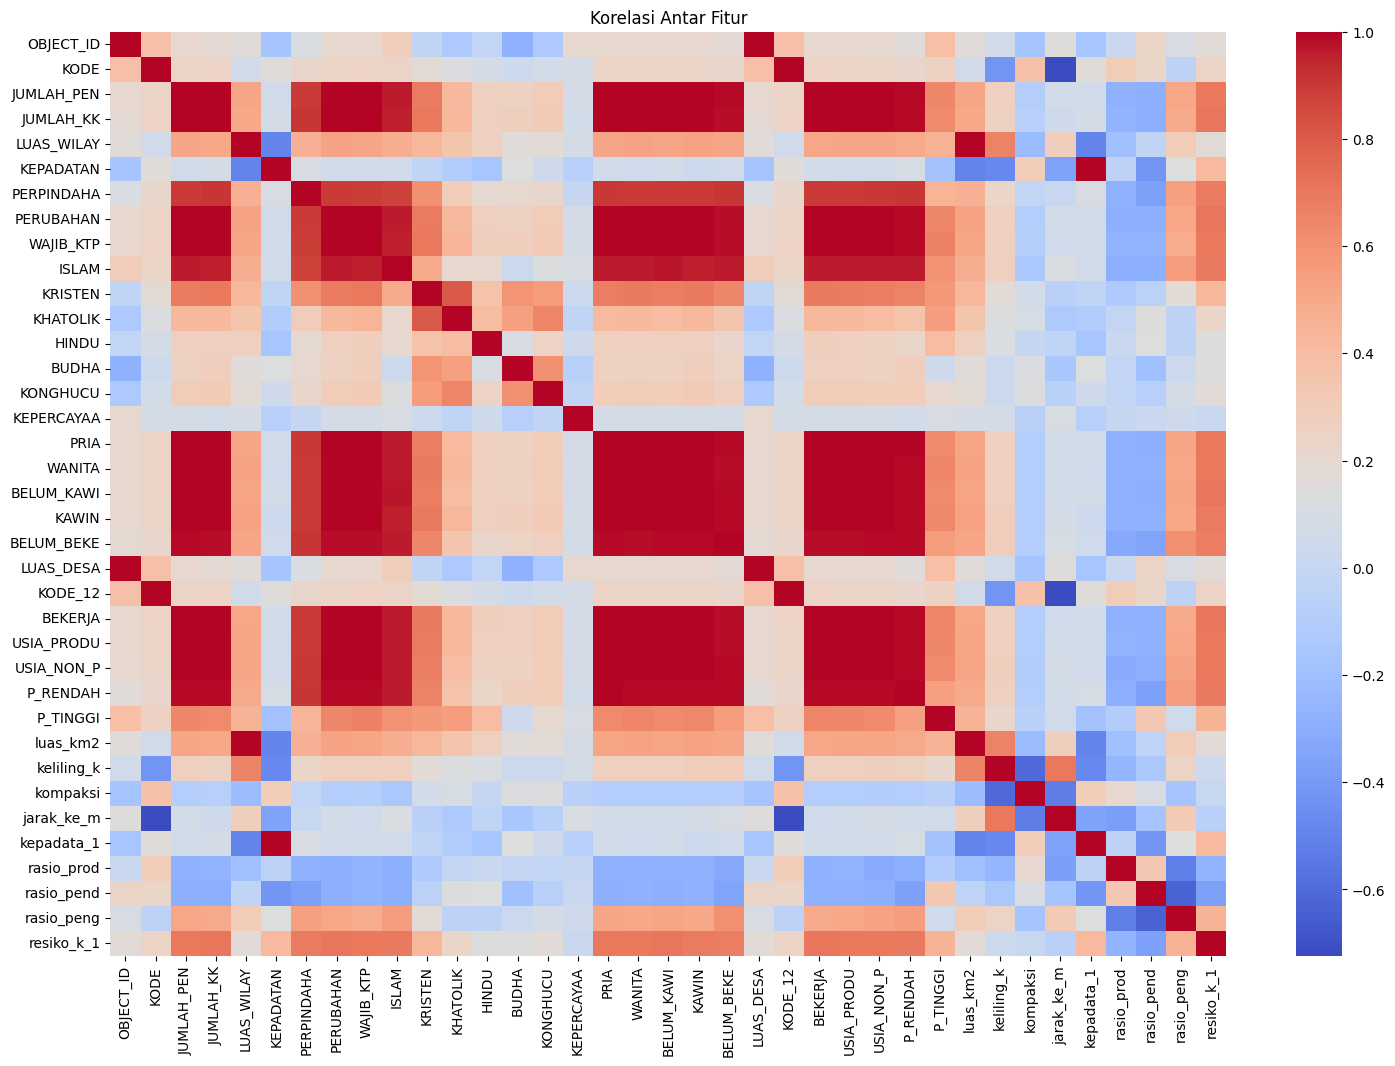

In [ ]:
# Visualisasikan dengan Heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Korelasi Antar Fitur')
plt.show()

In [ ]:
# Feature Selection
X = shp_file.drop(['KODE_DESA', 'DESA','PROVINSI','KAB_KOTA','KECAMATAN',
                       'DESA_KELUR','GENERATED','KODE_DES_1','KODE_DES_3',
                       'DESA_KEL_1','resiko_kre','resiko_k_1', 'geometry'], axis=1)
y = shp_file['resiko_k_1']

In [ ]:
# Membagi data menjadi X Train, y Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Membangun model random forest dan evaluasi model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.92      0.75      0.83        16
           2       0.90      1.00      0.95        28

    accuracy                           0.91        54
   macro avg       0.91      0.88      0.89        54
weighted avg       0.91      0.91      0.90        54



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

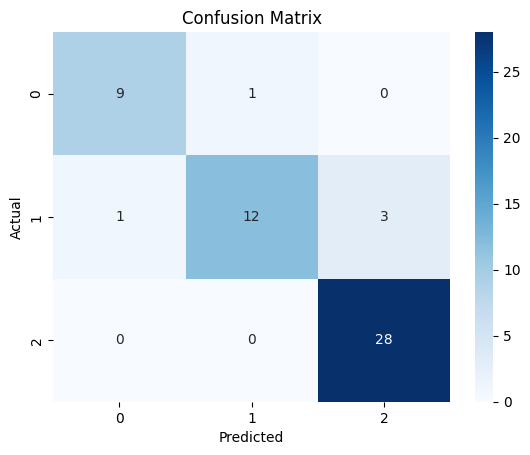

In [ ]:
# Visualisasi dengan menggunakan confussion matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt

In [ ]:
# Analisis Feature Importance
feature_importance = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

       Feature  Importance
6   PERPINDAHA    0.127225
26    P_RENDAH    0.093172
32  kepadata_1    0.075601
5    KEPADATAN    0.057206
3    JUMLAH_KK    0.051907
23     BEKERJA    0.051217
9        ISLAM    0.049460
16        PRIA    0.043687
18  BELUM_KAWI    0.042715
20  BELUM_BEKE    0.036315
17      WANITA    0.033633
24  USIA_PRODU    0.029321
25  USIA_NON_P    0.026968
2   JUMLAH_PEN    0.026771
19       KAWIN    0.025673
4   LUAS_WILAY    0.023693
8    WAJIB_KTP    0.021475
28    luas_km2    0.019759
34  rasio_pend    0.017712
29  keliling_k    0.017439
7    PERUBAHAN    0.013330
31  jarak_ke_m    0.013290
11    KHATOLIK    0.012166
10     KRISTEN    0.010181
0    OBJECT_ID    0.008814
35  rasio_peng    0.008432
27    P_TINGGI    0.008102
30    kompaksi    0.007908
33  rasio_prod    0.007276
21   LUAS_DESA    0.007276
1         KODE    0.006651
14    KONGHUCU    0.006488
12       HINDU    0.006151
22     KODE_12    0.006095
13       BUDHA    0.003673
15  KEPERCAYAA    0.003218


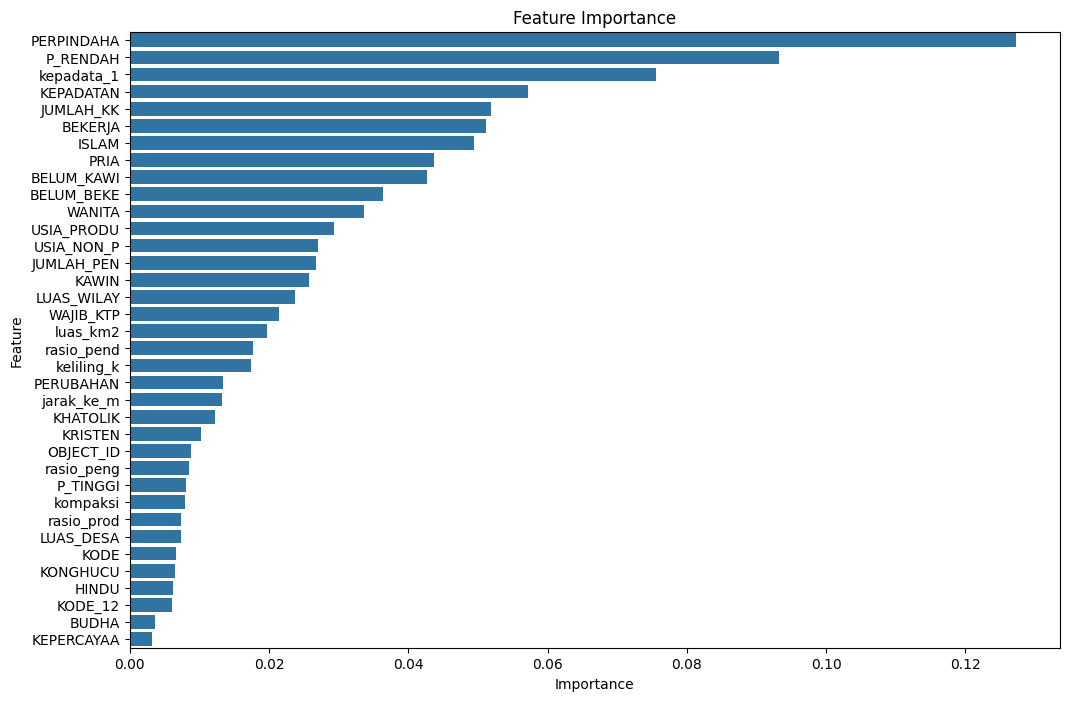

In [ ]:
# Visualisasi Feature Importance
plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [ ]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Inisialisasi GridSearchCV dengan RandomForestClassifier sebagai estimator
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),  # Model dasar yang akan dituning
                           param_grid=param_grid,   # Parameter yang akan dicoba satu per satu
                           cv=5,                    # Cross-validation sebanyak 5 fold
                           scoring='accuracy',      # Gunakan akurasi sebagai metrik evaluasi
                           n_jobs=-1,               # Gunakan semua core CPU untuk paralel proses
                           verbose=1)               # Tampilkan progres selama proses training

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [ ]:
# Evaluasi model setelah dilakukan HT
print('Best Parameter:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

Best Parameter: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8825027685492802


In [ ]:
# Simpan Best Model
best_model = grid_search.best_estimator_  # Simpan model terbaik berdasarkan evaluasi Grid Search

y_pred_best = best_model.predict(X_test)  # Gunakan model terbaik untuk prediksi data uji

shp_file['prediksi_rf'] = best_model.predict(X)
# Tampilkan hasil evaluasi model terbaik
print("\nEvaluasi Model Setelah Grid Search:")
print(classification_report(y_test, y_pred_best))  # Tampilkan metrik evaluasi: precision, recall, f1-score, dll



Evaluasi Model Setelah Grid Search:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.92      0.75      0.83        16
           2       0.90      1.00      0.95        28

    accuracy                           0.91        54
   macro avg       0.91      0.88      0.89        54
weighted avg       0.91      0.91      0.90        54



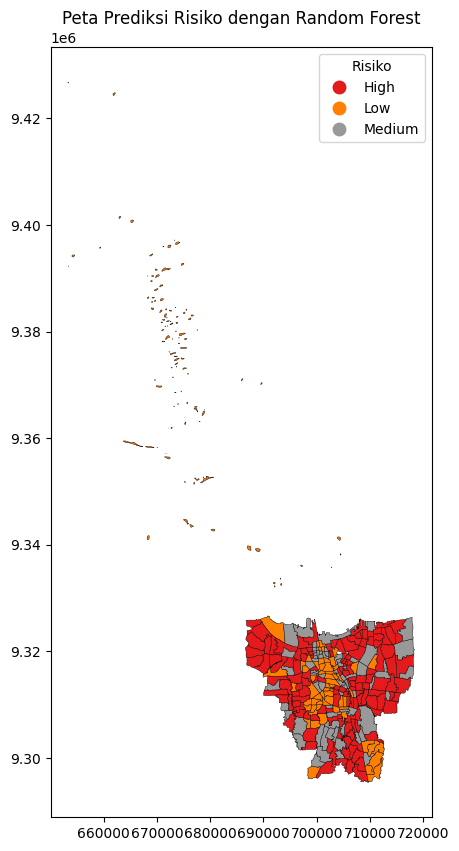

In [ ]:
# Visualisasi hasil Prediksi Random Forest

label_map = {0: 'Low', 1: 'Medium', 2: 'High'}
shp_file['prediksi_label'] = shp_file['prediksi_rf'].map(label_map)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

shp_file.plot(
    column='prediksi_label',
    categorical=True,
    legend=True,
    legend_kwds={'title': 'Risiko'},
    cmap='Set1',
    ax=ax,
    edgecolor='black',
    linewidth=0.3
)

ax.set_title('Peta Prediksi Risiko dengan Random Forest')
ax.axis('on')
plt.show()


In [ ]:
# Simpan dalam file baru
output = '/content/processed_jkt_rf.shp'
shp_file.to_file(output)

# **2. Segmentasi Citra**

In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 35.3 MB/s eta 0:00:00


In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [5]:
# Baca Data Raster
file = '/content/landsat8_dki_jakpus_2017.tif'
with rasterio.open(file) as src:
    band_data = src.read([2, 3, 4])

In [6]:
# Cek informasi data
bands, height, width = band_data.shape
print(band_data.shape)
print(band_data.dtype)

(3, 349, 334)
float64


In [7]:
# Pre Processing Data
blue = band_data[0].astype(float)
green = band_data[1].astype(float)
red = band_data[2].astype(float)

# Bersihkan data
# Ganti nilai NaN (kosong) menjadi 0 untuk menghidai eror
for band in [red, green, blue]:
    band[np.isnan(band)] = 0

In [8]:
# Ubah citra 3D menjadi 2D dengan Transform
image_reshaped = band_data.reshape(bands, height * width).T

# Pilih Valid Pixel
valid_pixels = ~np.isnan(image_reshaped).any(axis=1)
image_valid = image_reshaped[valid_pixels]

In [9]:
# Normalisasi Data
# Hitung nilai minimum dan maksimum untuk setiap band (R, G, B)
min_val = image_valid.min(axis=0)
max_val = image_valid.max(axis=0)

# Hitung rentang nilai (range = max - min)
range_val = max_val - min_val

# Jika ada band yang range-nya nol (semua nilainya sama), ubah jadi 1 agar tidak dibagi 0
range_val[range_val == 0] = 1

# Lakukan normalisasi min-max ke rentang [0, 1]
image_normalized = (image_valid - min_val) / range_val

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [11]:
# Buat Sample Acak untuk uji SSE dan SIL
sample = resample(image_normalized, n_samples=10000, random_state=42)

# Inisialisasi list kosong untuk menyimpan hasil evaluasi
sse = []
sil = []

# Uji jumlah cluster dari 2 sampai 6
for k in range(2, 6):
    model = KMeans(
      n_clusters=k,
      random_state=42
    ).fit(image_normalized)


    # Simpan nilai SSE (semakin kecil nilainya biasanya semakin baik)
    sse.append(model.inertia_)

    # Prediksi label cluster untuk data sample
    labels = model.predict(sample)

    # Hitung dan simpan Silhouette Score (semakin besar nilainya semakin baik)
    sil.append(silhouette_score(sample, labels))

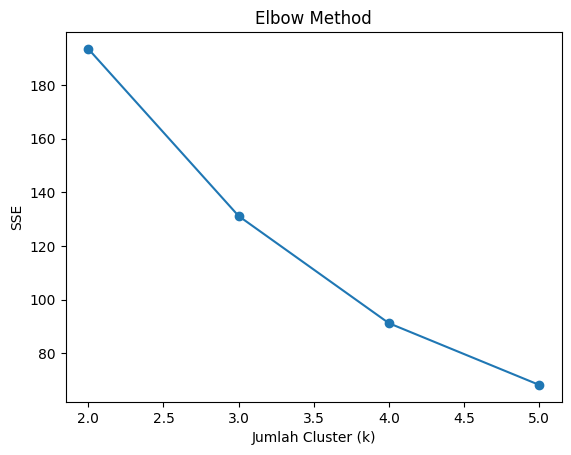

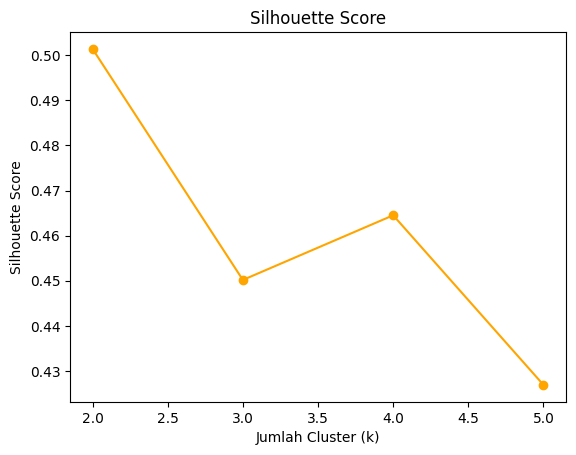

In [12]:
# Visualisasi SSE
plt.figure()
plt.plot(range(2, 6), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('SSE')
plt.show()

# Visualisasi Silhouette Score
plt.figure()
plt.plot(range(2, 6), sil, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [13]:
# Membangun model K-Means
jumlah_cluster = 4  # Jumlah klaster sesuai dengan hasil SSE/SIL

kmeans = KMeans(
    n_clusters=jumlah_cluster,
    random_state=42
)

cluster_labels = kmeans.fit_predict(image_normalized)

In [14]:
all_labels = -1 * np.ones(image_reshaped.shape[0], dtype=int)
all_labels[valid_pixels] = cluster_labels
clustered_image = all_labels.reshape(height, width)

Text(0.5, 1.0, 'Hasil KMeans Clustering (k=4)')

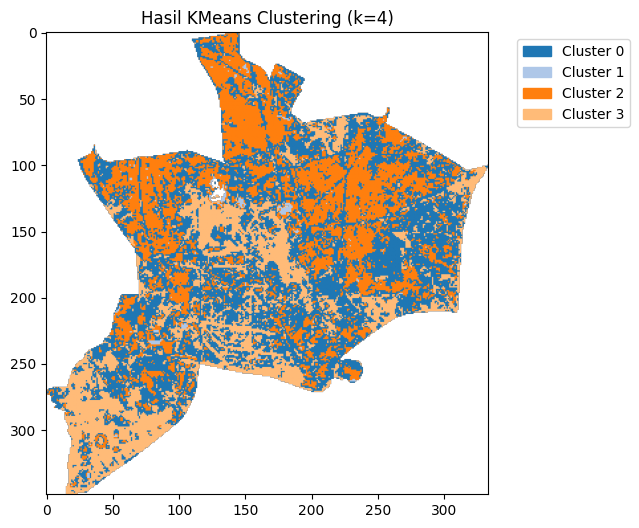

In [ ]:
# Visualisasi Hasil Segmentasi
masked_image = np.where(clustered_image == -1, np.nan, clustered_image)
cmap = plt.cm.tab20
custom_cmap = mcolors.ListedColormap(cmap.colors[:jumlah_cluster])

plt.figure(figsize=(8, 6))
plt.imshow(masked_image, cmap=custom_cmap)
legend_labels = [f'Cluster {i}' for i in range(jumlah_cluster)]
legend_patches = [mpatches.Patch(color=custom_cmap.colors[i], label=legend_labels[i])
                  for i in range(jumlah_cluster)]

# Tampilkan legend di luar plot sebelah kanan atas
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axis('on')

plt.title(f'Hasil KMeans Clustering (k={jumlah_cluster})')

In [ ]:
# Simpan hasil segmentasi
output = '/content/landsat8_dki_jakpus_2017_cluster.tif'
with rasterio.open(file) as src:
    meta = src.meta.copy()
meta.update({'count': 1,
             'dtype': 'int32',
             'nodata': -1})
with rasterio.open(output, 'w', **meta) as dst:
    dst.write(clustered_image.astype('int32'), 1)

# **3. Visualisasi Interaktif**

## **3.1 Folium Vektor**

In [ ]:
import folium

In [ ]:
# Baca Data
data = gpd.read_file('/content/processed_jkt_rf.shp')
print(data.columns)

Index(['OBJECT_ID', 'KODE_DESA', 'DESA', 'KODE', 'PROVINSI', 'KAB_KOTA',
       'KECAMATAN', 'DESA_KELUR', 'JUMLAH_PEN', 'JUMLAH_KK', 'LUAS_WILAY',
       'KEPADATAN', 'PERPINDAHA', 'PERUBAHAN', 'WAJIB_KTP', 'ISLAM', 'KRISTEN',
       'KHATOLIK', 'HINDU', 'BUDHA', 'KONGHUCU', 'KEPERCAYAA', 'PRIA',
       'WANITA', 'BELUM_KAWI', 'KAWIN', 'BELUM_BEKE', 'GENERATED',
       'KODE_DES_1', 'LUAS_DESA', 'KODE_DES_3', 'DESA_KEL_1', 'KODE_12',
       'BEKERJA', 'USIA_PRODU', 'USIA_NON_P', 'P_RENDAH', 'P_TINGGI',
       'resiko_kre', 'luas_km2', 'keliling_k', 'kompaksi', 'jarak_ke_m',
       'kepadata_1', 'rasio_prod', 'rasio_pend', 'rasio_peng', 'resiko_k_1',
       'prediksi_r', 'prediksi_l', 'geometry'],
      dtype='object')


In [ ]:
# Konversi nilai prediksi ke label kategori
label_map = {0: 'Low', 1: 'Medium', 2: 'High'}
data['prediksi_label'] = data['prediksi_r'].map(label_map)

# Mengatur warna untuk tiap kategori
color_dict = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}

In [ ]:
# Mengatur tampilan tiap fitur (poligon desa)
def style_function(feature):
    risk = feature['properties']['prediksi_label']
    return {
        'fillColor': color_dict.get(risk, 'gray'),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.6}


In [ ]:
# Membuat peta kosong
m = folium.Map(location=[-6.2, 106.8], zoom_start=10, tiles=None)

In [ ]:
# Membuat Basemap
#Tambahkan beberapa pilihan basemap agar pengguna bisa memilih
folium.TileLayer('CartoDB positron', attr='Map tiles by CartoDB, under CC BY 3.0').add_to(m)
# Menambahkan layer dasar peta 'CartoDB Positron' (tema terang) dengan atribusi lisensi
folium.TileLayer('CartoDB dark_matter', attr='Map tiles by CartoDB, under CC BY 3.0').add_to(m)
# Menambahkan layer dasar peta 'CartoDB Dark Matter' (tema gelap) dengan atribusi lisensi
folium.TileLayer('OpenStreetMap').add_to(m)
# Menambahkan layer dasar peta OpenStreetMap (peta standar open-source)

In [ ]:
# Menambahkan layer GeoJSON dari shapefile
folium.GeoJson(
    data,  #Data SHP
    name='Prediksi Risiko',  # Nama layer untuk ditampilkan di kontrol layer
    style_function=style_function,  # Menggunakan fungsi style_function untuk mengatur tampilan poligon
    tooltip=folium.GeoJsonTooltip(
        fields=['DESA', 'prediksi_label'],  # Kolom yang akan ditampilkan di tooltip (nama desa dan kategori risiko)
        aliases=['Desa:', 'Risiko:']  # Label alias untuk kolom di tooltip agar lebih mudah dibaca
    )
).add_to(m)

In [ ]:
m

In [ ]:
# Menambahkan Legend
from branca.element import Template, MacroElement

legend_html = """
{% macro html(this, kwargs) %}

<!-- North Arrow (kompas) -->
<div style="
    position: fixed;
    bottom: 10px;
    right: 10px;
    z-index: 9999;
">
    <img src="https://png.pngtree.com/png-clipart/20220905/ourmid/pngtree-arah-mata-angin-png-image_6138728.png" style="width:50px; height:50px;" />
</div>

<!-- Legend Box -->
<div style="
    position: fixed;
    bottom: 50px; left: 50px; width: 150px; height: 120px;
    border:2px solid grey; z-index:9999; font-size:14px;
    background-color:white; padding: 10px;
    ">
    <b>Legenda Risiko</b><br>
    <i style="background:green; width:10px; height:10px; display:inline-block;"></i>&nbsp;Low<br>
    <i style="background:orange; width:10px; height:10px; display:inline-block;"></i>&nbsp;Medium<br>
    <i style="background:red; width:10px; height:10px; display:inline-block;"></i>&nbsp;High<br>
</div>

{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)


In [ ]:
# Menambahkan kontrol layer agar pengguna bisa pilih basemap dan simpan hasil
folium.LayerControl().add_to(m)

m.save('peta_interaktif_prediksi_rf.html')

## **3.2 Folium Raster**

In [2]:
from matplotlib import colors
from PIL import Image

In [ ]:
# Buka Data
data = '/content/landsat8_dki_jakpus_2017_cluster.tif'
with rasterio.open(data) as src:
    kmeans_array = src.read(1)
    bounds = src.bounds
    nodata_val = src.nodata if src.nodata is not None else 0

In [ ]:
# Cek Unique Value
unique_classes = np.unique(kmeans_array[kmeans_array != nodata_val])
print("Kelas unik:", unique_classes)

Kelas unik: [0 1 2 3]


In [ ]:
# Membuat warna label sesuai dengan jumlah kelas
colors_list = ['yellow', 'black', 'brown', 'green']
cmap = colors.ListedColormap(colors_list)
boundaries = [-0.5 + i for i in range(len(unique_classes) + 1)]
norm = colors.BoundaryNorm(boundaries, ncolors=len(colors_list))

In [ ]:
# Ubah ke RGBA (dengan transparansi)
rgba_img = cmap(norm(kmeans_array))  # Mengonversi array K-Means ke format RGBA menggunakan colormap dan normalisasi
mask = (kmeans_array != nodata_val)  # Membuat mask boolean: True untuk data valid, False untuk nodata
rgba_img[..., 3] = mask.astype(float) * 0.8

In [ ]:
# Simpan ke PNG
rgba_img_255 = (rgba_img * 255).astype(np.uint8)  # Mengonversi nilai RGBA (0-1) ke rentang 0-255 untuk format gambar
image_pil = Image.fromarray(rgba_img_255, mode='RGBA')  # Membuat objek gambar PIL dari array RGBA
image_pil.save('hasil_kmeans.png')

In [ ]:
# Hitung bounds untuk overlay
bounds_latlon = [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]

In [ ]:
# Buat peta Folium
m = folium.Map(
    location=[(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2],  # Menentukan pusat peta berdasarkan rata-rata koordinat batas
    zoom_start=10  # Mengatur level zoom awal peta
)

In [ ]:
# Menambahkan base maps
folium.TileLayer('CartoDB positron', attr='Map tiles by CartoDB, under CC BY 3.0').add_to(m)  # Menambahkan layer peta dasar CartoDB Positron
folium.TileLayer('CartoDB dark_matter', attr='Map tiles by CartoDB, under CC BY 3.0').add_to(m)  # Menambahkan layer peta dasar CartoDB Dark Matter
folium.TileLayer('OpenStreetMap').add_to(m)  # Menambahkan layer peta dasar OpenStreetMap

In [ ]:
# Menambahkan hasil klasifikasi sebagai overlay
folium.raster_layers.ImageOverlay(
    name='Hasil KMeans',
    image='hasil_kmeans.png',
    bounds=bounds_latlon,
    opacity=1,
    interactive=True,
    cross_origin=False
).add_to(m)

In [ ]:
# Menambahkan kontrol layer
folium.LayerControl().add_to(m)

In [ ]:
# Simpan Hasil
m.save('peta_interaktif_kmeans.html')


# **4. Evaluasi dan Analisis**

Hasil klasifikasi awal dengan Random Forest menunjukkan performa yang cukup baik meskipun tanpa menggunakan Hyperparameter Tunning dengan akurasi keseluruhan 91% dan f1-score rata-rata 0.90. Kelas 2 memiliki hasil terbaik dengan f1-score 0.95, diikuti kelas 0 dengan 0.90. Namun, kelas 1 memiliki performa terendah, terutama pada recall yang hanya 0.75, menunjukkan model sering keliru mendeteksi kelas ini. Confusion matrix juga memperlihatkan sebagian sampel kelas 1 terklasifikasi sebagai kelas lain, kemungkinan karena kemiripan ciri spektral atau jumlah sampel yang lebih sedikit. Secara umum, model sudah baik sebagai baseline, namun masih perlu penyempurnaan untuk meningkatkan hasil pada kelas 1.

Setelah dilakukan hyperparameter tuning, model terbaik diperoleh dengan parameter:
max_depth=10, n_estimators=200, min_samples_split=2, min_samples_leaf=1, bootstrap=True, menghasilkan skor validasi silang (Best Score) sebesar 0.88.

Namun, hasil evaluasi pada data uji menunjukkan bahwa performa model tidak banyak berubah dibandingkan sebelum tuning. Akurasi tetap di angka 91%, dengan pola f1-score per kelas yang sama: kelas 2 masih menjadi yang terbaik (0.95), kelas 0 baik (0.90), dan kelas 1 tetap yang terendah (0.83) terutama pada recall (0.75). Hal ini menunjukkan bahwa model baseline sudah cukup optimal, dan tuning yang dilakukan belum berhasil memperbaiki kelemahan pada kelas 1 secara signifikan. Untuk meningkatkan lagi, mungkin diperlukan strategi lain seperti penyeimbangan data, eksplorasi fitur tambahan, atau teknik ensemble yang lebih kompleks.

---

Untuk Segmentasi citra dengan menggunakan K-Means menggunakan evaluasi yang sedikit berbeda dengan Model Machine Learning sebelumnya dikarenakan metode tersebut merupakan metode Unsupervised Learning. Sehingga metode evaluasi yang digunakan adalah SSE (Sum of Squared Error) atau Elbow Method, dan Silhouette Score. Dari hasil uji SSE dan Silhouette Score, jumlah cluster optimal terlihat pada k=4. Elbow pada SSE cukup jelas di k=4, dan Silhouette Score relatif tinggi pada titik tersebut. Secara visual, hasil segmentasi juga menunjukkan pola spasial yang konsisten dan dapat dibedakan dengan jelas antar cluster. Distribusi ukuran cluster pun merata tanpa dominasi satu cluster yang ekstrem. Hasil ini menunjukkan bahwa model K-Means sudah cukup baik untuk memetakan area homogen di wilayah studi.